In [1]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from transformers import RobertaForSequenceClassification, RobertaTokenizer, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from torch.optim import AdamW

In [2]:
df = pd.read_csv('/kaggle/input/text-js-rep/text_gen_mmn.csv')

In [3]:
df.head()

,Text,MMN_Label
0,The average household income of an individual ...,1
1,The average household income of an individual ...,0
2,The average household income of an individual ...,1
3,The average household income of an individual ...,1
4,The average household income of an individual ...,1


In [4]:
df['MMN_Label'].value_counts()

MMN_Label
1    180
0    129
Name: count, dtype: int64

<Axes: xlabel='MMN_Label', ylabel='count'>

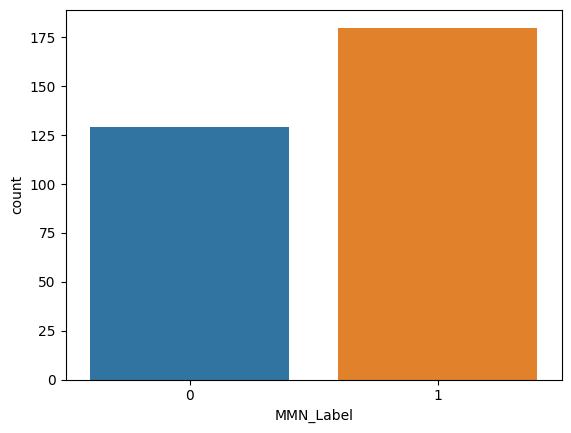

In [5]:
sns.countplot(x=df['MMN_Label'])

In [6]:
texts = df['Text'].values
labels = df['MMN_Label'].values

In [7]:
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)

In [8]:
# Define Dataset class
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index):
        text = self.texts[index]
        label = self.labels[index]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [9]:
# Load model and tokenizer
model_name = 'roberta-base'
tokenizer = RobertaTokenizer.from_pretrained(model_name)
model = RobertaForSequenceClassification.from_pretrained(model_name, num_labels=2)

# Create Datasets and DataLoaders
train_dataset = TextDataset(train_texts, train_labels, tokenizer, max_len=512)
val_dataset = TextDataset(val_texts, val_labels, tokenizer, max_len=512)
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False)

# Define optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=1e-5)
epochs = 20
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# Move model to GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = model.to(device)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
# Early Stopping Class
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0


In [11]:
# Training Loop with Early Stopping
early_stopping = EarlyStopping(patience=3, min_delta=0.001)

for epoch in range(epochs):
    model.train()
    train_loss = 0
    
    for batch in train_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        scheduler.step()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_dataloader)

    # Validation step
    model.eval()
    val_loss = 0
    val_preds = []
    val_labels_list = []

    with torch.no_grad():
        for batch in val_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            val_loss += loss.item()

            logits = outputs.logits
            _, preds = torch.max(logits, dim=1)
            val_preds.extend(preds.cpu().numpy())
            val_labels_list.extend(labels.cpu().numpy())

    avg_val_loss = val_loss / len(val_dataloader)
    val_accuracy = accuracy_score(val_labels_list, val_preds)

    print(f"Epoch {epoch+1}/{epochs}")
    print(f"Train Loss: {avg_train_loss:.4f} | Validation Loss: {avg_val_loss:.4f} | Validation Accuracy: {val_accuracy:.4f}")

    # Check early stopping
    early_stopping(avg_val_loss)
    if early_stopping.early_stop:
        print("Early stopping triggered.")
        break

print("Training finished.")

Epoch 1/20
Train Loss: 0.6859 | Validation Loss: 0.6860 | Validation Accuracy: 0.5484
Epoch 2/20
Train Loss: 0.6722 | Validation Loss: 0.6849 | Validation Accuracy: 0.5484
Epoch 3/20
Train Loss: 0.6788 | Validation Loss: 0.6865 | Validation Accuracy: 0.5484
Epoch 4/20
Train Loss: 0.6711 | Validation Loss: 0.6730 | Validation Accuracy: 0.5484
Epoch 5/20
Train Loss: 0.6558 | Validation Loss: 0.6501 | Validation Accuracy: 0.5484
Epoch 6/20
Train Loss: 0.6255 | Validation Loss: 0.6392 | Validation Accuracy: 0.7258
Epoch 7/20
Train Loss: 0.5739 | Validation Loss: 0.6405 | Validation Accuracy: 0.6290
Epoch 8/20
Train Loss: 0.5583 | Validation Loss: 0.6028 | Validation Accuracy: 0.7419
Epoch 9/20
Train Loss: 0.5368 | Validation Loss: 0.6212 | Validation Accuracy: 0.6613
Epoch 10/20
Train Loss: 0.5314 | Validation Loss: 0.5621 | Validation Accuracy: 0.7581
Epoch 11/20
Train Loss: 0.4988 | Validation Loss: 0.5421 | Validation Accuracy: 0.7419
Epoch 12/20
Train Loss: 0.4755 | Validation Loss: 0.

Accuracy: 0.7258
Precision: 0.7576
Recall: 0.7353
F1 Score: 0.7463
ROC AUC Score: 0.8004


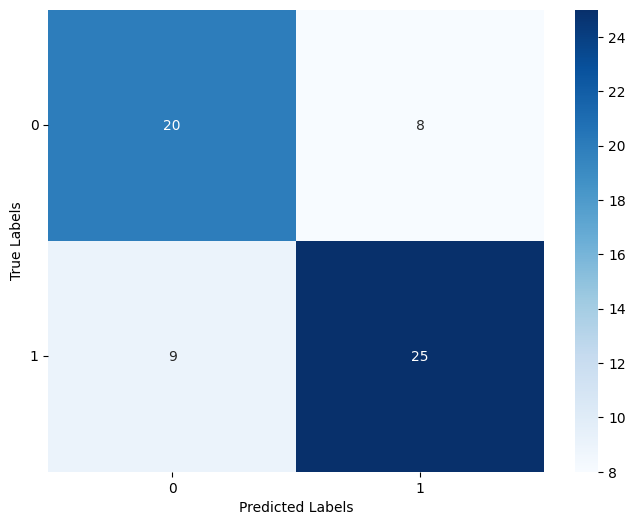

----------------------

[0.         0.         0.         0.03571429 0.03571429 0.07142857
 0.07142857 0.10714286 0.10714286 0.14285714 0.14285714 0.17857143
 0.17857143 0.21428571 0.21428571 0.28571429 0.28571429 0.32142857
 0.32142857 0.39285714 0.39285714 0.46428571 0.46428571 0.82142857
 0.82142857 1.        ]
[0.         0.02941176 0.05882353 0.05882353 0.08823529 0.08823529
 0.29411765 0.29411765 0.41176471 0.41176471 0.52941176 0.52941176
 0.67647059 0.67647059 0.70588235 0.70588235 0.76470588 0.76470588
 0.85294118 0.85294118 0.88235294 0.88235294 0.97058824 0.97058824
 1.         1.        ]
[1.9568975  0.95689744 0.9550417  0.94957024 0.9476884  0.9432413
 0.9163983  0.91429037 0.8887173  0.86173105 0.81134176 0.8097735
 0.7319596  0.68878156 0.65892583 0.60259825 0.48113108 0.47574845
 0.30988306 0.27419704 0.19719973 0.17317459 0.09466581 0.07234476
 0.07144167 0.06703849]
----------------------



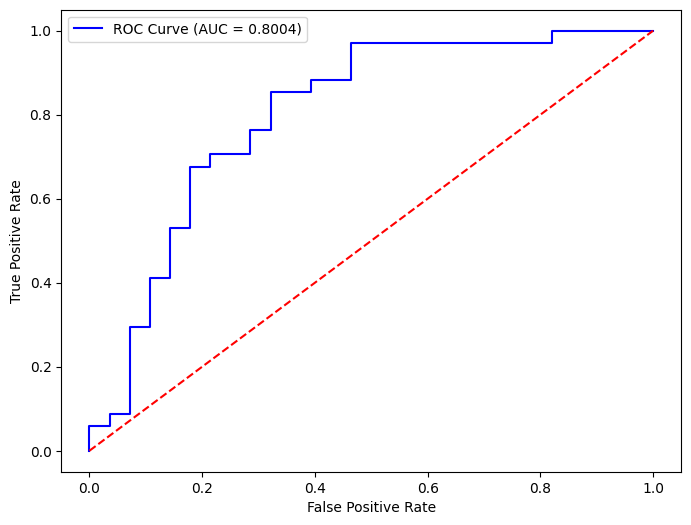

In [12]:
# Final Evaluation on Validation Set
model.eval()

all_preds = []
all_labels = []
all_probs = []

for batch in val_dataloader:
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['labels'].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probs = torch.nn.functional.softmax(logits, dim=1)
        _, preds = torch.max(logits, dim=1)

    all_preds.extend(preds.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())
    all_probs.extend(probs.cpu().numpy()[:, 1])  

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

# Compute Metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
roc_auc = roc_auc_score(all_labels, all_probs)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")

# Plot Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Create the plot
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=True)

# Labels, title, and ticks
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks([0.5, 1.5], ['0', '1'])
plt.yticks([0.5, 1.5], ['0', '1'], rotation=0)

# Display the plot
plt.show()

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(all_labels, all_probs)

print("----------------------\n")
print(fpr)
print(tpr)
print(thresholds)
print("----------------------\n")

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()